# Library

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [2]:
import gdown
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna

# Load the Data

In [3]:
train_file_id = '1vMhm8aUdTW2LytxEMqejOETBi1z3CDHA'
train_output_file = '/content/train.csv'
train_download_url = f'https://drive.google.com/uc?id={train_file_id}'
gdown.download(train_download_url, train_output_file, quiet=False)
df_train = pd.read_csv(train_output_file, encoding='ISO-8859-1')

test_file_id = '1yZim54qcb0gvG1clLok6dZsPfUE-03Kf'
test_output_file = '/content/test.csv'
test_download_url = f'https://drive.google.com/uc?id={test_file_id}'
gdown.download(test_download_url, test_output_file, quiet=False)
df_test = pd.read_csv(test_output_file, encoding='ISO-8859-1')

Downloading...
From: https://drive.google.com/uc?id=1vMhm8aUdTW2LytxEMqejOETBi1z3CDHA
To: /content/train.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 45.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yZim54qcb0gvG1clLok6dZsPfUE-03Kf
To: /content/test.csv
100%|██████████| 1.00M/1.00M [00:00<00:00, 10.2MB/s]


# Data Information

## Train

In [4]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
obj = [col for col in df_train.columns if df_train[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_train[col].nunique()}")
  print(f"Unique Values: {df_train[col].unique()}")
  print("Value Counts:")
  print(df_train[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Value Counts:
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64
--------------------------------------------------


## Test

In [7]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [9]:
obj = [col for col in df_test.columns if df_test[col].nunique() <= 10]

for col in obj:
  print(f"Column: {col}")
  print(f"Number of Unique Values (nunique): {df_test[col].nunique()}")
  print(f"Unique Values: {df_test[col].unique()}")
  print("Value Counts:")
  print(df_test[col].value_counts())
  print("-" * 50)

Column: Sentiment
Number of Unique Values (nunique): 5
Unique Values: ['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Value Counts:
Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64
--------------------------------------------------


# Data Cleaning

In [10]:
df_train.duplicated().sum()

0

## Remove Columns

In [11]:
cols = ['UserName','ScreenName','Location','TweetAt']
df_train.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

# Data Preprocessing

## Text Preprocessing

In [12]:
def clean_text(text):
  text = re.sub(r"http\S+", "", text) # URL
  text = re.sub(r"@\w+", "", text) # Mention
  text = re.sub(r"#\w+", "", text) # Hashtag
  text = re.sub(r"\d+", "", text) # Number
  text = re.sub(r"<.*?>", "", text) #HTML
  text = re.sub(r"[^\w\s]", "", text) # Punctuation
  text = text.lower()
  return text.strip()

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(clean_text)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(clean_text)

In [13]:
df_train.head()

,OriginalTweet,Sentiment
0,and and,Neutral
1,advice talk to your neighbours family to excha...,Positive
2,coronavirus australia woolworths to give elder...,Positive
3,my food stock is not the only one which is emp...,Positive
4,me ready to go at supermarket during the outb...,Extremely Negative


## Stopword and Lemmatizer

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def remove_stopwords_lemmatize(text):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
  return ' '.join(words)

df_train['OriginalTweet'] = df_train['OriginalTweet'].apply(remove_stopwords_lemmatize)
df_test['OriginalTweet'] = df_test['OriginalTweet'].apply(remove_stopwords_lemmatize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Mapping

In [15]:
df_train['Sentiment'].value_counts()

,count
Sentiment,
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


In [16]:
def map_sentiment(x):
  if x == "Positive" or x == "Extremely Positive":
    return 1
  if x == "Negative" or x == "Extremely Negative":
    return 2
  if x == "Neutral":
    return 0

df_train['Sentiment'] = df_train['Sentiment'].apply(map_sentiment)
df_test['Sentiment'] = df_test['Sentiment'].apply(map_sentiment)

## Remove Missing Values

In [17]:
df_train.dropna(subset=['OriginalTweet'], inplace=True)

# WordCloud

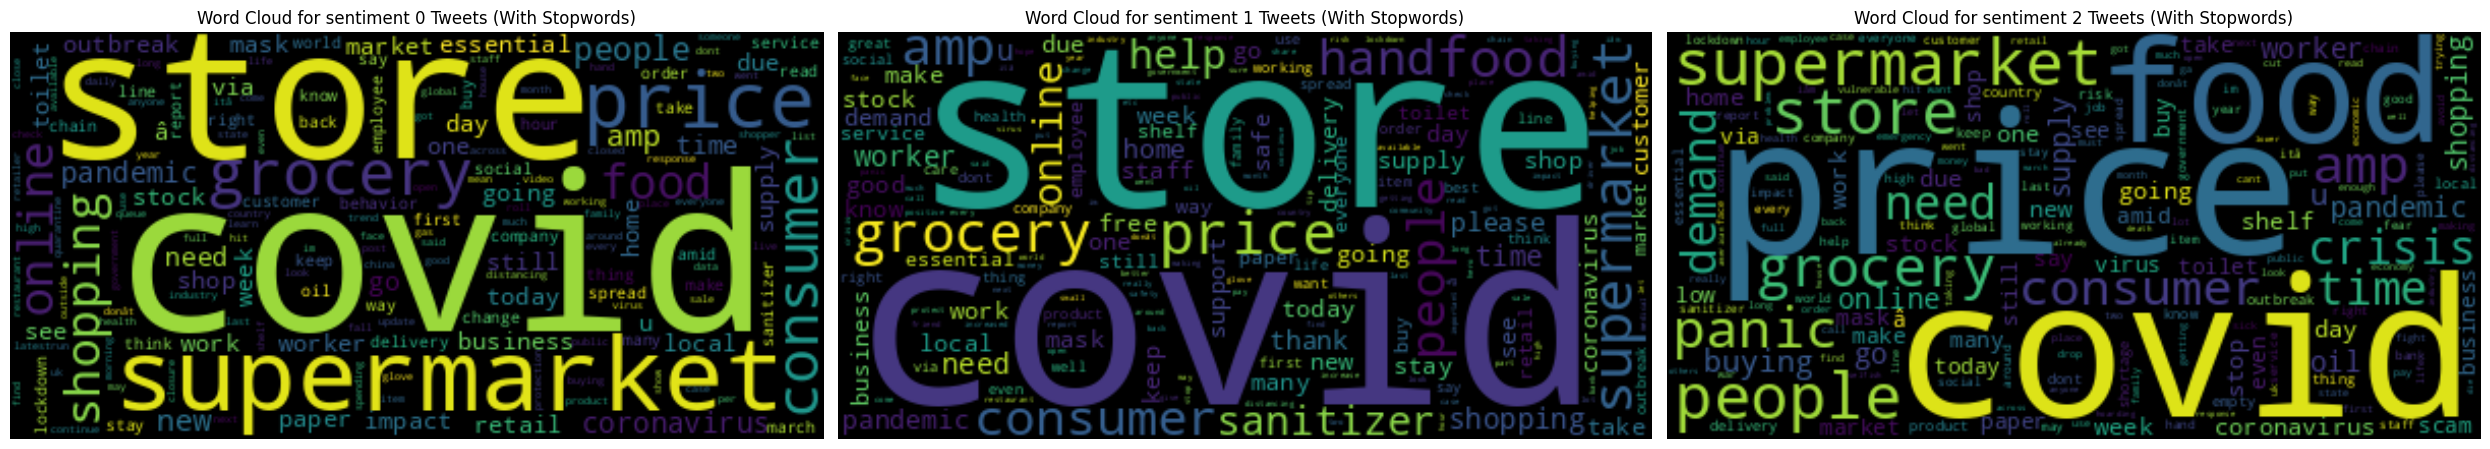

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
sentiments = [0, 1, 2]

for i, sentiment in enumerate(sentiments):
  opinion = ' '.join(df_train[df_train['Sentiment'] == sentiment]['OriginalTweet'])
  ax = axes[i]
  wordcloud = WordCloud(max_words=2000, width=400, height=200, collocations=False).generate(opinion)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis("off")
  ax.set_title(f"Word Cloud for sentiment {sentiment} Tweets (With Stopwords)")

plt.tight_layout()
plt.show()

# Modeling

In [19]:
from sklearn.model_selection import train_test_split
X = df_train['OriginalTweet']
y = df_train['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify = y)

## TFIDF

In [20]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## LR

In [21]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.5f}")

              precision    recall  f1-score   support

           0       0.76      0.63      0.69      1543
           1       0.83      0.87      0.85      3609
           2       0.80      0.83      0.82      3080

    accuracy                           0.81      8232
   macro avg       0.80      0.78      0.78      8232
weighted avg       0.81      0.81      0.81      8232

Test Accuracy: 0.80831


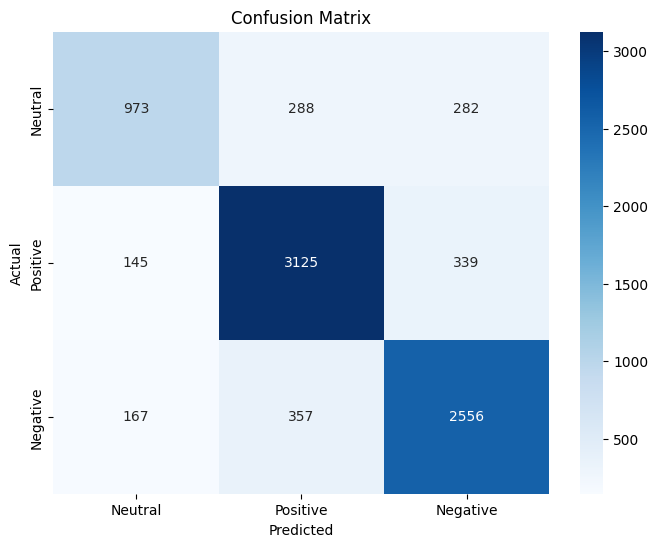

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Neutral', 'Positive', 'Negative'],
            yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter

In [23]:
def crossval(X, y, n_folds=5, random_state=42, model=None):
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
  accuracy_scores = []

  for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    fold_accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(fold_accuracy)

    print(f"Fold {fold + 1}: Accuracy Score: {fold_accuracy:.5f}")

  avg_accuracy = np.mean(accuracy_scores)
  print(f"Average Accuracy Score: {avg_accuracy:.5f}")

  return avg_accuracy

In [24]:
def objective_lr(trial):
  params = {
      'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
  }

  model = LogisticRegression(**params)
  scores = crossval(X, y, model=model)
  return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=5)

[I 2024-11-23 11:03:26,163] A new study created in memory with name: no-name-4228b53e-e030-4d1a-b377-3f7f017caa44
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Accuracy Score: 0.81280


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Accuracy Score: 0.81596


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Accuracy Score: 0.81570


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: Accuracy Score: 0.81400


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-11-23 11:03:56,228] Trial 0 finished with value: 0.8143936638126101 and parameters: {'C': 11.272592916400315}. Best is trial 0 with value: 0.8143936638126101.


Fold 5: Accuracy Score: 0.81351
Average Accuracy Score: 0.81439


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Accuracy Score: 0.81706


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Accuracy Score: 0.81730


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Accuracy Score: 0.81436
Fold 4: Accuracy Score: 0.81315


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-11-23 11:04:28,068] Trial 1 finished with value: 0.8159486246205443 and parameters: {'C': 2.4137702550703484}. Best is trial 1 with value: 0.8159486246205443.


Fold 5: Accuracy Score: 0.81788
Average Accuracy Score: 0.81595


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Accuracy Score: 0.80357


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Accuracy Score: 0.80709


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Accuracy Score: 0.80452


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: Accuracy Score: 0.80318


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-11-23 11:05:09,105] Trial 2 finished with value: 0.8037757097389175 and parameters: {'C': 136.09059315613223}. Best is trial 1 with value: 0.8159486246205443.


Fold 5: Accuracy Score: 0.80051
Average Accuracy Score: 0.80378


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Accuracy Score: 0.81657


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Accuracy Score: 0.81633


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Accuracy Score: 0.81801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: Accuracy Score: 0.81339


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-11-23 11:05:47,929] Trial 3 finished with value: 0.8164346277240785 and parameters: {'C': 7.9063450566729605}. Best is trial 3 with value: 0.8164346277240785.


Fold 5: Accuracy Score: 0.81788
Average Accuracy Score: 0.81643


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 1: Accuracy Score: 0.81025


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2: Accuracy Score: 0.81001


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3: Accuracy Score: 0.80877


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4: Accuracy Score: 0.81084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2024-11-23 11:06:21,597] Trial 4 finished with value: 0.810481830582173 and parameters: {'C': 1.326151345977562}. Best is trial 3 with value: 0.8164346277240785.


Fold 5: Accuracy Score: 0.81254
Average Accuracy Score: 0.81048


In [25]:
final_logreg_params = {
    'C': study.best_params['C'],
    'max_iter': 1000,
}

final_model_lr = LogisticRegression(**final_logreg_params)

scores = crossval(X, y, model=final_model_lr, n_folds=5, random_state=42)
print(f"Final Model Average Accuracy: {np.mean(scores):.5f}")

Fold 1: Accuracy Score: 0.81293
Fold 2: Accuracy Score: 0.81851
Fold 3: Accuracy Score: 0.81764
Fold 4: Accuracy Score: 0.81497
Fold 5: Accuracy Score: 0.81533
Average Accuracy Score: 0.81588
Final Model Average Accuracy: 0.81588
